# Paleoclimate Data Processing

This notebook processes paleoclimate data and aligns it with demographic timelines.

## Steps:
1. Load occurrence data
2. Download/Load climate data
3. Extract climate data for occurrence points
4. Align climate data with PSMC time scale
5. Create climate time series


In [23]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import xarray as xr
import rasterio
from rasterio.transform import from_bounds
import geopandas as gpd
from pathlib import Path
import yaml
from IPython.display import display

with open('config.yaml', 'r') as f:
    config = yaml.safe_load(f)

DATA_DIR = Path(config['data_dir'])
OUTPUT_DIR = Path(config['output_dir'])
OUTPUT_DIR.mkdir(exist_ok=True, parents=True)

print(f"Data directory: {DATA_DIR}")
print(f"Output directory: {OUTPUT_DIR}")

Data directory: data
Output directory: outputs


### 3. Download GBIF occurrence points (new cell)

In [24]:
from pygbif import occurrences as gbif_occ

metadata = pd.read_excel(DATA_DIR / "metadata.xlsx")
species_list = (metadata['GENUS'].str.strip() + ' ' + metadata['SPECIES'].str.strip()).dropna().unique()

records = []
for species in species_list:
    resp = gbif_occ.search(scientificName=species, has_coordinate=True, limit=300)
    for rec in resp.get("results", []):
        lat = rec.get("decimalLatitude")
        lon = rec.get("decimalLongitude")
        if lat is None or lon is None:
            continue
        records.append({
            "scientific_name": species,
            "latitude": lat,
            "longitude": lon,
            "eventDate": rec.get("eventDate"),
            "basisOfRecord": rec.get("basisOfRecord"),
            "country": rec.get("country"),
            "gbif_id": rec.get("key")
        })

occurrences_gbif = pd.DataFrame(records).drop_duplicates(subset=["scientific_name", "latitude", "longitude"])
OUTPUT_DIR.mkdir(exist_ok=True, parents=True)
occurrence_csv = OUTPUT_DIR / "occurrence_points_gbif.csv"
occurrences_gbif.to_csv(occurrence_csv, index=False)
print(f"Saved {len(occurrences_gbif)} records to {occurrence_csv}")

Saved 1707 records to outputs/occurrence_points_gbif.csv


### 4. Preview head/tail (new cell right after step 3)

In [15]:
if occurrence_csv.exists():
    print(f"Columns: {occurrences_gbif.columns.tolist()}")
    print("\nHead:")
    display(occurrences_gbif.head())
    print("\nTail:")
    display(occurrences_gbif.tail())
else:
    print("Occurrence CSV missing—run the GBIF download cell first.")


Columns: ['scientific_name', 'latitude', 'longitude', 'eventDate', 'basisOfRecord', 'country', 'gbif_id']

Head:


,scientific_name,latitude,longitude,eventDate,basisOfRecord,country,gbif_id
0,Semnopithecus entellus,24.356754,70.755160,2025-01-01T15:48,HUMAN_OBSERVATION,Pakistan,5036803148
1,Semnopithecus entellus,26.034595,76.464220,2025-01-20T08:57:13,HUMAN_OBSERVATION,India,5063191048
2,Semnopithecus entellus,26.352505,73.035316,2025-01-15T17:54:23,HUMAN_OBSERVATION,India,5063206506
3,Semnopithecus entellus,20.612318,79.868953,2025-01-13T08:26,HUMAN_OBSERVATION,India,5063235352
4,Semnopithecus entellus,20.612181,79.869096,2025-01-12T11:13:10,HUMAN_OBSERVATION,India,5063308084



Tail:


,scientific_name,latitude,longitude,eventDate,basisOfRecord,country,gbif_id
1889,Trachypithecus pileatus,27.318687,91.138344,2015-04-01,HUMAN_OBSERVATION,Bhutan,4516691887
1890,Trachypithecus pileatus,27.311541,91.113488,2015-04-01,HUMAN_OBSERVATION,Bhutan,4516696944
1891,Trachypithecus pileatus,26.782673,91.148574,2015-05-02T19:56,HUMAN_OBSERVATION,India,1500313101
1892,Trachypithecus pileatus,26.632312,94.347208,2015-05-08,HUMAN_OBSERVATION,India,1571057114
1893,Trachypithecus pileatus,26.917725,92.872184,2015-08-23T16:41,HUMAN_OBSERVATION,India,3802576178


### 5. Step 1 – Load occurrences for downstream use

In [25]:
if occurrence_csv.exists():
    occurrences = occurrences_gbif[['latitude', 'longitude']].rename(
        columns={'latitude': 'latitude', 'longitude': 'longitude'}
    )
    full_metadata = occurrences_gbif
    print(f"Using {len(occurrences)} GBIF occurrence points")
else:
    metadata_file = DATA_DIR / "metadata.xlsx"
    occurrences, full_metadata = load_occurrence_data(metadata_file)

Using 1707 GBIF occurrence points


### 6. Step 2 – Raster helpers

In [26]:
def load_climate_raster(climate_file, variable_name):
    """
    Load a climate raster (GeoTIFF) into memory.
    Returns the data array plus transform/CRS info for coordinate lookups.
    """
    with rasterio.open(climate_file) as src:
        data = src.read(1)
        transform = src.transform
        crs = src.crs
        bounds = src.bounds

    return {
        "data": data,
        "transform": transform,
        "crs": crs,
        "bounds": bounds,
        "variable": variable_name,
    }


def extract_climate_at_points(climate_raster, points_df):
    """
    Sample climate values at each latitude/longitude in points_df.
    Skips rows that fall outside the raster or have nodata values.
    """
    from rasterio.transform import rowcol

    values = []
    valid_points = []

    for idx, row in points_df.iterrows():
        lon, lat = row["longitude"], row["latitude"]

        row_idx, col_idx = rowcol(climate_raster["transform"], lon, lat)

        if (
            0 <= row_idx < climate_raster["data"].shape[0]
            and 0 <= col_idx < climate_raster["data"].shape[1]
        ):
            value = climate_raster["data"][row_idx, col_idx]
            if not np.isnan(value) and value != -9999:
                values.append(value)
                valid_points.append(idx)

    return np.array(values), valid_points

### 7. Step 3 – Climate time series (update directory)

In [29]:
def create_climate_time_series(climate_dir, time_periods, variables, occurrences_df):
    """Aggregate climate values for each time period across all occurrence points."""
    time_series_data = []

    for period in time_periods:
        period_data = {"time_period": period}

        for var in variables:
            candidate_paths = [
                climate_dir / f"{var}_{period}ka.tif",
                climate_dir / f"{period}ka" / f"{var}.tif"
            ]
            file_path = next((p for p in candidate_paths if p.exists()), None)

            if file_path is None:
                print(f"Warning: no raster found for {var} at {period}ka")
                continue

            raster = load_climate_raster(file_path, var)
            values, _ = extract_climate_at_points(raster, occurrences_df)

            if len(values) > 0:
                period_data[f"{var}_mean"] = np.mean(values)
                period_data[f"{var}_std"] = np.std(values)
                period_data[f"{var}_min"] = np.min(values)
                period_data[f"{var}_max"] = np.max(values)
            else:
                print(f"Warning: no valid samples for {var} at {period}ka (check overlap or nodata values)")

        time_series_data.append(period_data)

    return pd.DataFrame(time_series_data)


CLIMATE_DIR = DATA_DIR / "paleoclim"
time_periods = [0, 6, 12, 21]
variables = config.get('climate_data', {}).get('variables', ['bio1', 'bio12'])

if CLIMATE_DIR.exists() and occurrences is not None and not occurrences.empty:
    climate_series = create_climate_time_series(CLIMATE_DIR, time_periods, variables, occurrences)
    climate_series['time_years'] = climate_series['time_period'] * 1000
    results_csv = OUTPUT_DIR / "climate_time_series.csv"
    climate_series.to_csv(results_csv, index=False)
    print(f"\nClimate time series created with {len(climate_series)} rows and saved to {results_csv}")
    display(climate_series)
else:
    print("Cannot create climate time series. Check that CLIMATE_DIR exists and occurrences are loaded.")


Climate time series created with 4 rows and saved to outputs/climate_time_series.csv


,time_period,time_years
0,0,0
1,6,6000
2,12,12000
3,21,21000


### 8. Step 4 – Plot climate series

In [ ]:
def create_climate_time_series(period_folders, variables, occurrences_df):
    """
    Aggregate climate values for each time period across all occurrence points.
    `period_folders` maps the numeric time (ka) to the folder containing bio*.tif files.
    """
    time_series_data = []

    for period, folder in period_folders.items():
        period_data = {"time_period": period}

        if folder is None or not folder.exists():
            print(f"Warning: folder for {period}ka not found ({folder})")
            time_series_data.append(period_data)
            continue

        for var in variables:
            # variables like 'bio1' -> file bio_1.tif (Paleoclim naming)
            tif_name = f"bio_{var[3:]}.tif" if var.startswith("bio") else f"{var}.tif"
            file_path = folder / tif_name

            if not file_path.exists():
                print(f"Warning: raster {file_path} missing")
                continue

            raster = load_climate_raster(file_path, var)
            values, _ = extract_climate_at_points(raster, occurrences_df)

            if len(values) > 0:
                period_data[f"{var}_mean"] = np.mean(values)
                period_data[f"{var}_std"] = np.std(values)
                period_data[f"{var}_min"] = np.min(values)
                period_data[f"{var}_max"] = np.max(values)
            else:
                print(f"Warning: no valid samples for {var} at {period}ka")

        time_series_data.append(period_data)

    return pd.DataFrame(time_series_data)


period_folders = {
    0: DATA_DIR / "paleoclim" / "LH_v1_2_5m",
    6: DATA_DIR / "paleoclim" / "MH_v1_2_5m",
    12: DATA_DIR / "paleoclim" / "EH_v1_2_5m",
    21: DATA_DIR / "paleoclim" / "LGM_v1_2_5m",
}

variables = config.get("climate_data", {}).get("variables", ["bio1", "bio12"])

if occurrences is not None and not occurrences.empty:
    climate_series = create_climate_time_series(period_folders, variables, occurrences)
    climate_series["time_years"] = climate_series["time_period"] * 1000
    results_csv = OUTPUT_DIR / "climate_time_series.csv"
    climate_series.to_csv(results_csv, index=False)
    print(
        f"\nClimate time series created with {len(climate_series)} rows and saved to {results_csv}"
    )
    display(climate_series)
else:
    print("Cannot create climate time series. Occurrence data are missing.")


Climate time series created with 4 rows and saved to outputs/climate_time_series.csv


,time_period,bio1_mean,bio1_std,bio1_min,bio1_max,bio12_mean,bio12_std,bio12_min,bio12_max,time_years
0,0,202.527241,61.051504,-23,276,2030.541886,908.616522,277,5853,0
1,6,135.547745,1381.998528,-32768,270,2163.302285,2807.839957,277,65535,6000
2,12,186.550088,64.201136,-47,265,2071.823667,906.828155,269,5740,12000
3,21,167.492091,60.268384,-97,238,1785.383714,750.285261,166,3276,21000


Saved plot: outputs/climate_time_series.png


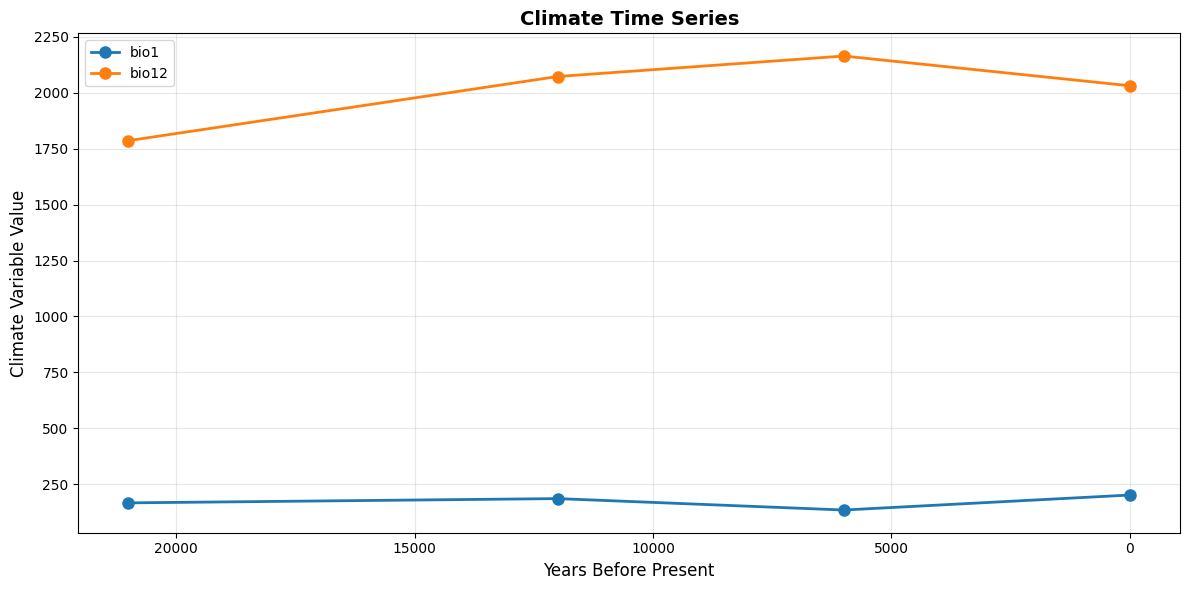


Climate data processing complete!


In [33]:
def plot_climate_time_series(climate_df, output_file=None):
    """
    Plot each climate variable’s mean value through time (older to newer).
    """
    fig, ax = plt.subplots(figsize=(12, 6))

    for var in variables:
        mean_col = f"{var}_mean"
        if mean_col in climate_df.columns:
            ax.plot(
                climate_df["time_years"],
                climate_df[mean_col],
                marker="o",
                label=var,
                linewidth=2,
                markersize=8,
            )

    ax.set_xlabel("Years Before Present", fontsize=12)
    ax.set_ylabel("Climate Variable Value", fontsize=12)
    ax.set_title("Climate Time Series", fontsize=14, fontweight="bold")
    ax.legend()
    ax.grid(True, alpha=0.3)
    ax.invert_xaxis()

    plt.tight_layout()

    if output_file:
        plt.savefig(output_file, dpi=300, bbox_inches="tight")
        print(f"Saved plot: {output_file}")

    plt.show()
    return fig


results_csv = OUTPUT_DIR / "climate_time_series.csv"
if results_csv.exists():
    climate_df = pd.read_csv(results_csv)
    plot_climate_time_series(climate_df, OUTPUT_DIR / "climate_time_series.png")
    print("\nClimate data processing complete!")
else:
    print("Climate time series not found. Run the previous steps first.")

Saved static plot: outputs/climate_time_series.png


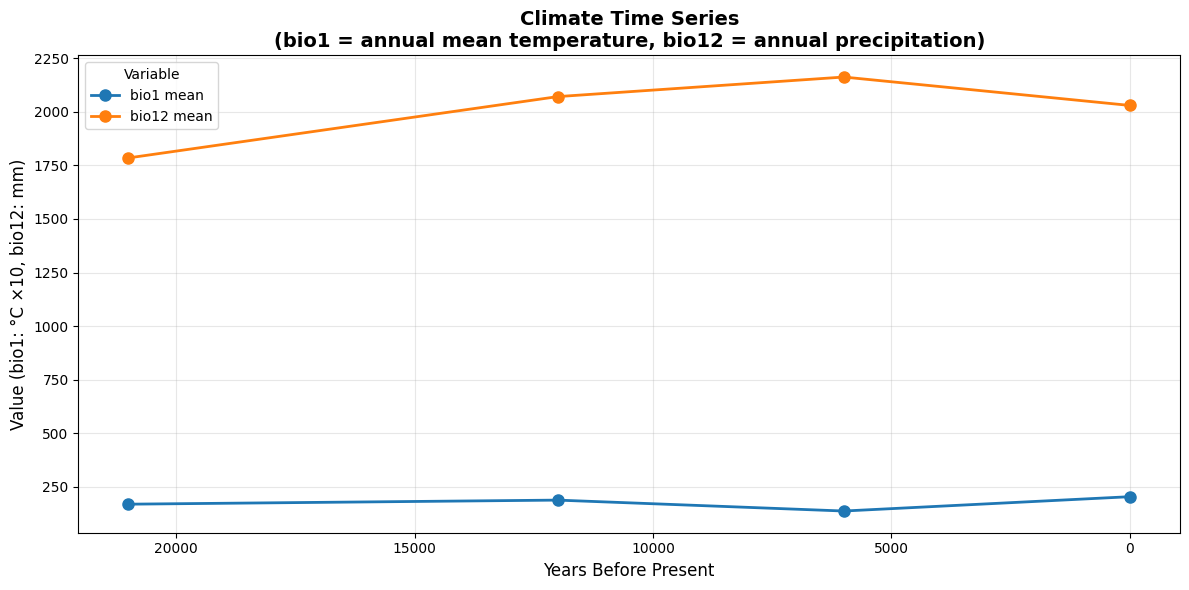


Climate data processing complete!


In [34]:
import plotly.express as px

def plot_climate_time_series(climate_df, output_file=None):
    """
    Plot climate variables over time using Matplotlib (static) and Plotly (interactive).
    bio1 = annual mean temperature (°C ×10), bio12 = annual precipitation (mm).
    """
    if climate_df is None or climate_df.empty:
        print("No climate data available to plot.")
        return None

    # --- Static Matplotlib plot ---
    fig, ax = plt.subplots(figsize=(12, 6))

    plotted_vars = []
    for var in variables:
        mean_col = f"{var}_mean"
        if mean_col in climate_df.columns:
            ax.plot(
                climate_df["time_years"],
                climate_df[mean_col],
                marker="o",
                label=f"{var} mean",
                linewidth=2,
                markersize=8,
            )
            plotted_vars.append(mean_col)

    ax.set_xlabel("Years Before Present", fontsize=12)
    ax.set_ylabel("Value (bio1: °C ×10, bio12: mm)", fontsize=12)
    ax.set_title(
        "Climate Time Series\n(bio1 = annual mean temperature, bio12 = annual precipitation)",
        fontsize=14,
        fontweight="bold",
    )
    ax.legend(title="Variable")
    ax.grid(True, alpha=0.3)
    ax.invert_xaxis()
    plt.tight_layout()

    if output_file:
        plt.savefig(output_file, dpi=300, bbox_inches="tight")
        print(f"Saved static plot: {output_file}")

    plt.show()

    # --- Interactive Plotly plot ---
    if plotted_vars:
        melted = (
            climate_df[["time_years"] + plotted_vars]
            .rename(columns={col: col.replace("_mean", "") for col in plotted_vars})
            .melt(id_vars="time_years", var_name="Variable", value_name="Value")
        )
        interactive_fig = px.line(
            melted,
            x="time_years",
            y="Value",
            color="Variable",
            markers=True,
            title="Interactive Climate Time Series",
            labels={
                "time_years": "Years Before Present",
                "Value": "Value (bio1: °C ×10, bio12: mm)",
            },
        )
        interactive_fig.update_layout(xaxis_autorange="reversed")
        interactive_fig.show()
    else:
        interactive_fig = None
        print("No variables available to plot interactively.")

    return interactive_fig


results_csv = OUTPUT_DIR / "climate_time_series.csv"
if results_csv.exists():
    climate_df = pd.read_csv(results_csv)
    plot_climate_time_series(climate_df, OUTPUT_DIR / "climate_time_series.png")
    print("\nClimate data processing complete!")
else:
    print("Climate time series not found. Run the previous steps first.")